# DBS Readout Model
## Discrete Network

A lot of recent effort in DBS research has focused on identifying neural signals that track with disease state.
These *disease readouts* can objectively inform whether DBS is working and whether therapy changes are appropriate.
Not a lot of effort has focused on developing a systematic framework to finding these readouts, however.

In this notebook we'll develop a theoretical approach to designing and assessing neural readouts for diseases.

In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats

import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [15, 10]

### Our model
We start with a simple Graph $\mathcal{G}$.
A disease mapping $\Xi \in \mathbb{R}^D$ transforms from the neural statespace to the behavioral statespace.
A measurement mapping $h: X \rightarrow Y$ yields us our electrophysiologic measurements $\vec{y}(t)$.
The goal of a readout is to accurately predict the behavioral state $\beta$ from just the measurements $\vec{y}(t)$.

Unlike the previous example, we're going to now have correlations between our brain nodes.

## Perfect Model

Starting with the same model we have before:
![](Assets/discrete_model.png)

We're going to add in network structure.
Basically, regions won't have independent activity anymore and will have co-dependence:

![]()


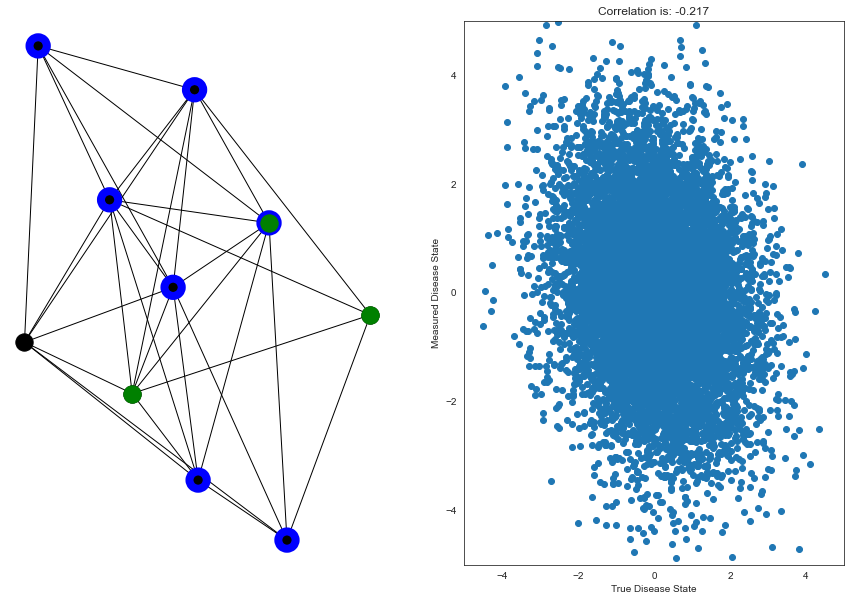

In [2]:
def overlap(b7=0.15,b8=0.15,m1=1, m2=1, m3=1,h_noise=1):
    node_n = 10
    G = nx.erdos_renyi_graph(node_n,0.8)
    
    # Set up our disease map
    beta = np.array([0.1,0.1,0.1,0.1,0.1,0.1,b7,b8,0.0,0.0]).reshape(-1,1)
    beta = beta/np.linalg.norm(beta)

    # Set up our measurement map
    h = np.array([0,0,0,0,0,0,m1,m2,m3,1]).reshape(-1,1)
    h = h/np.linalg.norm(h,ord=1)

    # How many observations do we have
    trials = 10000

    # What's the noise in each brain region
    x_sigma = 1.0
    covar_matrix = x_sigma * nx.laplacian_matrix(G).todense()
    
    x = np.random.multivariate_normal(mean=np.zeros((node_n,)),cov=covar_matrix,size=(1,trials)).T.squeeze()
    # Now calculate our disease measure and recordings
    c = np.dot(beta.T,x)
    y = np.dot(h.T,x)

    # Add in noise to our recording if we want to
    y += np.random.normal(0,h_noise,size=y.shape)

    max_ip = np.dot(c,y.T)
    max_corr = stats.pearsonr(c.squeeze(),y.squeeze())
    
    plt.figure()
    plt.subplot(121)
    pos = nx.spring_layout(G)
    nx.draw(G,pos=pos,node_color='black')
    dz_nodes = nx.draw_networkx_nodes(G,pos=pos,nodelist=range(0,7),node_color='none',linewidths=8.0)
    dz_nodes.set_edgecolor('blue')
    nx.draw_networkx_nodes(G,pos=pos,nodelist=[6,7,8],node_color='green')

    plt.subplot(122)
    plt.scatter(c,y)
    plt.xlim((-5,5))
    plt.ylim((-5,5))
    plt.xlabel('True Disease State')
    plt.ylabel('Measured Disease State')
    plt.title('Correlation is: ' + str(np.round(max_corr[0],4)))
    
overlapper = interactive(overlap,m1=(0,1.0,0.05),m2=(0,1.0,0.05),m3=(0,1.0,0.05),b7=(0.0,1.0,0.05),b8=(0.0,1.0,0.05),h_noise=(0.0,10.0,0.5))
display(overlapper)

#print(h)

#print(1/trials * max_ip/(np.std(c)*np.std(y)))

## How good is good enough?
We've put a limit on how good a readout can be compared to perfect.
Here we'll see how we can go about figuring out if a readout is *good enough*